# Designing Experiments

One of the tasks of an academic is to construct experiments that discern which of a set of competing theories best explains reality. In some sense, this task is the opposite to that of robust policy design. In designing policy, we want to identify actions that give a favorable result under any of the plausible system structures.

By contrast, in designing an experiment, we want to identify a policy that gives as different a result as possible under various different assumptions about system structure. Then by putting the policy into place and observing the result, we have we have a clear signal as to which policy is a better representation of the underlying system.

In this notebook, we'll explore using system dynamics modeling to help design these experiments. For now, we'll just look at the system in a deterministic fashion, to determine the general type of experiment that we should conduct. This analysis would normally be followed with an uncertainty analysis on parameters to identify how many samples would be needed and to evaluate the statistical process to be followed on experimental results.

In this example, we'll design a test between two competing theories of how the tenure of an insurance company sales agent changes in response to the various incentives they are given.

The first theory claims that agents' productivity is a function of their motivation, and their motivation adjusts to reflect their level of success. 

A reinforcing loop is drawn in which more successful agents become more motivated, perform better, and become yet more motivated; and vice versa.

However, if agents motivation falls below a certain level, they choose to leave to work somewhere else.
<img src="../../models/Sales_Agents/Sales_Agent_Motivation_Dynamics.png" alt="Sales agent motivation model" style="width: 700px;"/>


The second theory is more nuanced. In this theory, the agent distinguishes between high payout clients, and low payout clients. In order to have access to high payout clients, the agent must make sales to low payout clients and get their referrals to their higher payout friends. 
<img src="../../models/Sales_Agents/Sales_Agent_Market_Building_Dynamics.png" alt="Sales agent startup model" style="width: 700px;"/>

Under this scenario, agents aren't earning a living making sales only to low payout clients, and may leave if they are not able to gain access to the market of high payout clients before they run out of savings.

<img src="../../models/Sales_Agents/Sales_Agent_Market_Building_Dynamics_2.png" alt="Sales agent startup buffer" style="width: 650px;"/>


The metric we are interested in observing is the 'tenure', or lifespan of an agent. In trying to encourage agents to stay, managers might give a subsidy to new agents to help them get started. We'll use the amount and duration of this subsidy as our experimental levers.

In [1]:
%pylab inline
import pysd
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/houghton/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


We begin by importing both of the models of behavior, giving them each a different name. The first model which is driven by the agent's motivation we'll call the `motivation_model`; the second, which is driven by the startup dynamics of the sales market, we'll term the `market_model`.

In [2]:
motivation_model = pysd.read_vensim('../../models/Sales_Agents/Sales_Agent_Motivation_Dynamics.mdl')
market_model = pysd.read_vensim('../../models/Sales_Agents/Sales_Agent_Market_Building_Dynamics.mdl')

To simplify things later on, we construct a function which takes a particular policy set and applies it to each of the models, and formats the output of the models. We'll use this function to evaluate the performance of each of the models in the base case of no policy.

In [3]:
def runner(params):
    market = market_model.run(dict(params),return_columns=['Tenure'])
    motiv = motivation_model.run(dict(params),return_columns=['Tenure'])
    return pd.Series({'market':market['Tenure'].iloc[-1], 
                      'motivation':motiv['Tenure'].iloc[-1]})

As the models are not fully calibrated, they give different results in the base case. What we will do in our analysis is to compare the changes that result from various policies as a fraction of the base case.

In [35]:
base = runner({'Startup Subsidy': 0,
              'Startup Subsidy Length': 0})
base

market         6.875
motivation    10.625
dtype: float64

The first test we'll make looks at the response to increasing the startup subsidy for a fixed duration:

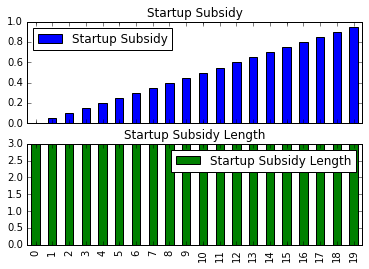

In [36]:
subsidy = pd.DataFrame(np.arange(0,1,.05), columns=['Startup Subsidy'])
subsidy['Startup Subsidy Length'] = 3
subsidy.plot(subplots=True, kind='bar');

We can now use our helper function to run the model for each of these values of startup subsidy, and plot the result of each model. We see that while the intervention does increase employee tenure with respect to the baseline, it does so almost equally for the two models. While this would be a good policy choice, it is not a good choice of experimental manipulation, as we can't use the results of our experiment to distinguish between the two options.

In [37]:
subsidy_res = subsidy.apply(runner, axis=1)/base

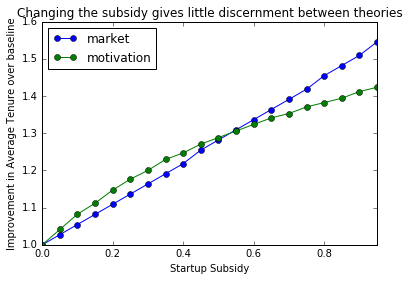

In [38]:
subsidy_res.index = subsidy['Startup Subsidy']
subsidy_res.plot(style='o-')
plt.ylabel('Improvement in Average Tenure over baseline')
plt.title('Changing the subsidy gives little discernment between theories');

The next intervention we could make would be to use a fixed amount of subsidy, but vary the length of time over which it is offered.

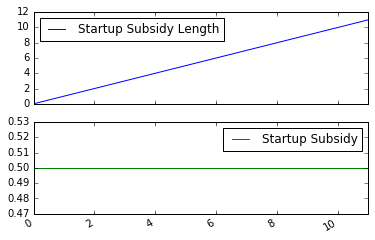

In [27]:
l_subsidy = pd.DataFrame(np.arange(0,12,1), 
                       columns=['Startup Subsidy Length'])
l_subsidy['Startup Subsidy'] = .5
l_subsidy.plot(subplots=True);

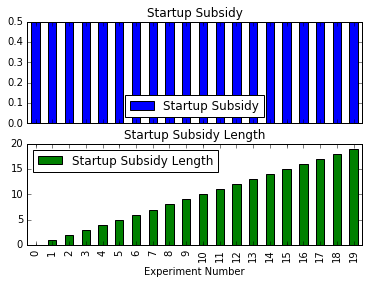

In [43]:
l_subsidy = pd.DataFrame(index=range(20), 
                         data=0.5,
                         columns=['Startup Subsidy'])
l_subsidy['Startup Subsidy Length'] = range(20)
l_subsidy.plot(subplots=True, kind='bar')
plt.xlabel('Experiment Number');

This intervention gives us more clear distinction between the two models, with the market based model responding more strongly to the intervention with longer subsidy lengths. In this case, we could use this strategy and sample a number of points to see if we see the change in the slope of the response curve or not.

In [44]:
l_subsidy_res = l_subsidy.apply(runner, axis=1)/base

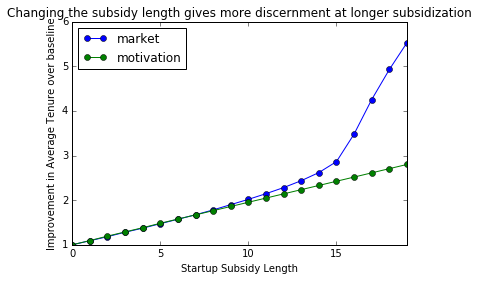

In [45]:
l_subsidy_res.index = l_subsidy['Startup Subsidy Length']
l_subsidy_res.plot(style='o-')
plt.ylabel('Improvement in Average Tenure over baseline');
plt.title('Changing the subsidy length gives more discernment at longer subsidization');

A third intervention we could try would be to hold the total dollar value given out in subsidies to an agent over time to be fixed, and vary whether we give it out quickly or slowly.

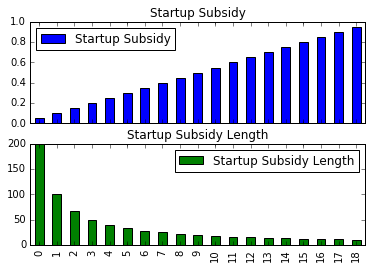

In [46]:
total_subsidy = pd.DataFrame(np.arange(0.05,1,.05), 
                       columns=['Startup Subsidy'])
total_subsidy['Startup Subsidy Length'] = 10/total_subsidy['Startup Subsidy']
total_subsidy.plot(subplots=True, kind='bar');

This third option turns out to be quite interesting. As we vary the rate at which we give the startup subsidy, the curves resulting from the two models move in qualitatively different directions. If we concieve of agents using a startup subsidy to help pad their buffer until they can get their client base established, then all of the impact comes from having support until the high value clients begin to pay. 

On the other hand, if we concieve of agents using the subsidy to support their motivation, then they stay as long as they are making above whatever threshold they have for dropping out. 

In [47]:
total_subsidy_res = total_subsidy.apply(runner, axis=1)

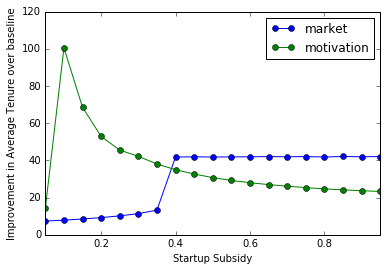

In [49]:
total_subsidy_res.index = total_subsidy['Startup Subsidy']
total_subsidy_res.plot(style='o-')
plt.ylabel('Improvement in Average Tenure over baseline');

We can conduct this experiment giving subsidies at slower rates to some individuals, and faster rates to other individuals, and assess the relative change in their behaviors, to assess which of our two models is more representative of reality.